# The Spectrum of Digitally Modulated Signals

We have described the construction of linearly modulated signals in the time-domain:
$$
s(t) = \sum_n s[n] \cdot p(t-nT).
$$

In this notebook, we illustrate computing the power-spectral density (PSD) of digitally modulated signals for full-response pulses, i.e., pulses that span exactly one symbol period.

In [2]:
# import standard libraries",
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")

## PSD of digitally modulated signals

We have shown in class that the PSD $S(f)$ depends on:
* the average symbol energy $E_s$
* the symbol duration $T$ or the symbol rate $R=1/T$
* and the pulse shape $p(t)$ (via it's Fourier transform $P(f)$)

The PSD of the modulated signal is given by:
$$
    S(f) = \frac{E_s}{T} |P(f)|^2. 
$$.

For many pulses, the PSD can be computed. In this notebook, we also show how to compute it numerically from samples of the pulse shape $p(t)$.

### Example: Rectangular Pulse

The rectangular pulse is defined as
$$
p_r(t) = \begin{cases}
    \frac{1}{\sqrt{T}} & \text{for $0\leq t < T$}\\
    0 & \text{else.}
\end{cases}
$$

The Fourier Transform for this pulse is well known:
$$
P_r(f) = \sqrt{T} \text{sinc}(\pi f T) e^{-j\pi f T}.
$$

Therefore, the power spectral density of a digitally modulated signal with rectangular pulse shaping is
$$
S(f) = E_s \cdot \text{sinc}^2(\pi f T).
$$

We can compute this Fourier transform easily.

In [3]:
def FT_rect_pulse(ff, T=1):
    """compute the Fourier transform of a rectangular pulse"""

    return np.sinc(ff * T)  # np.sinc includes pi!

### Example: Half-Sine Pulse

A smoother pulse is the half-sine pulse, defined as
$$
p_{hs}(t) = \begin{cases}
\sqrt{\frac{2}{T}} \sin(\pi t / T) & \text{for $0 \leq t < T$}\\
0 & \text{else.}
\end{cases}
$$

The Fourier transform of this pulse is also readily computed. It is equal to 
$$
P_{hs}(f) = \sqrt{2T} \cdot \frac{2}{\pi} \cdot \frac{\cos(\pi fT)}{1-4(fT)^2} \cdot e^{-j\pi fT}.
$$
The value of $P(f)$ when $4(fT)^2 = 1$, can be computed using L'Hospital's rule: $P_{hs}(\frac{1}{2T}) = \sqrt{\frac{T}{2}}$.

Here is a function to compute $P_{hs}(f)$.

In [4]:
def FT_half_sine_pulse(ff, T=1):
    """Compute the Fourier transform of the half-sine pulse"""
    # find the frequencies that must be dealt with separately
    f_crit  = np.abs((np.abs(ff) - 0.5/T)) < 1e-8
    f_safe = ff[f_crit]
    ff[f_crit] = 0

    # compute all the non-critical values
    P = np.sqrt(2*T) * 2/np.pi * np.cos(np.pi*ff*T) / (1-4*(ff*T)**2)
    
    # insert the critical values
    P[f_crit] = np.sqrt(T/2)

    # restore ff
    ff[f_crit] = f_safe

    return P * np.exp(-1j*np.pi*ff*T)
    

### Comparison of Power Spectral Densities

With the two Fourier transforms in hand, we can compare the power spectral densities for signals transmitted with either of these pulses.

For simplicity, we will assume that
* average symbol energy $E_s = 1$ and
* symbol period $T=1$.
Then, the PSD is equal to $|P(f)|^2$

We plot the PSD for both signals

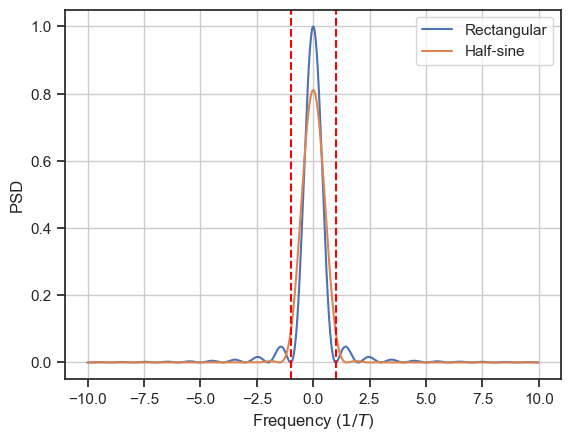

In [5]:
Es = 1
T = 1
# make a frequency grid; 1024 points between -fmax and fmax
fmax = 10/T
ff = np.arange(-fmax, fmax, 2*fmax/1024)

plt.plot(ff, np.abs(FT_rect_pulse(ff, 1))**2, label='Rectangular')
plt.plot(ff, np.abs(FT_half_sine_pulse(ff, 1))**2, label='Half-sine')

plt.grid()
plt.xlabel('Frequency ($1/T$)')
plt.ylabel('PSD')

plt.axvline(T, color='red', linestyle='--')
plt.axvline(-T, color='red', linestyle='--')

plt.legend()

plt.show()

#### Observations:

* The two spectra are very similar:
  + the power is concentrated in the *main lobe* between $-1/T$ and $1/T$.
  * outside the main lobe the power decays for frequencies away from the center

* Differences include:
  + the spectrum of the rectangular pulse is slightly taller and narrower 
  + the side lobes of the half-sine pulse decay more quickly

* Details of the side-lobe decay are difficult to discern: **plot spectra on a logarithmic scale (in dB)**

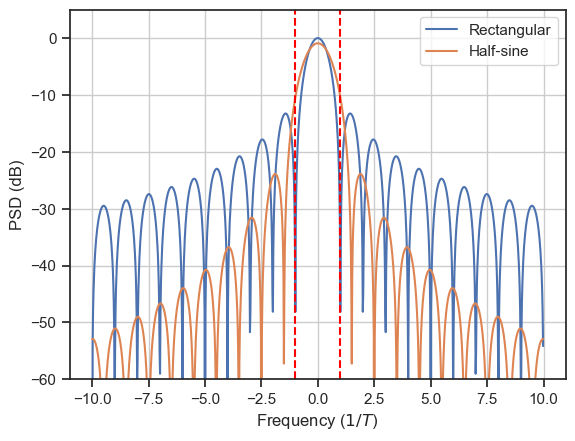

In [6]:
plt.plot(ff, 10*np.log10(np.abs(FT_rect_pulse(ff, 1))**2), label='Rectangular')
plt.plot(ff, 10*np.log10(np.abs(FT_half_sine_pulse(ff, 1))**2), label='Half-sine')

plt.grid()
plt.xlabel('Frequency ($1/T$)')
plt.ylabel('PSD (dB)')

plt.axvline(T, color='red', linestyle='--')
plt.axvline(-T, color='red', linestyle='--')

plt.legend()
plt.ylim(-60, 5)

plt.show()

* On the logarithmic scale, it is very clear that the side-lobes of the half-sine pulse decay much more quickly.
 + for the rectangular pulse, side-lobes decay like $1/|f|^2$
 + for the half-sine pulse, decay is proportional to $1/|f|^4$.

* This is an import difference!
  * assume that out-of-band emissions must be 40dB lower than the peak of the PSD
  * the half-sine pulse, meets this requirement for $|f| >5/T$.
  * the rectangular pulse does not reach this level for the frequencies shown here.

* Let's look at the center of the PSD more closely.

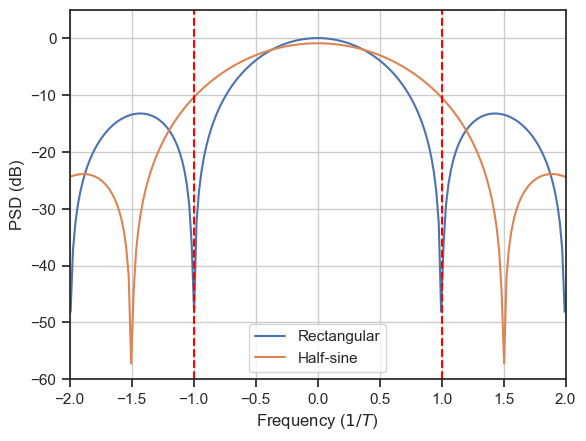

In [7]:
plt.plot(ff, 10*np.log10(np.abs(FT_rect_pulse(ff, 1))**2), label='Rectangular')
plt.plot(ff, 10*np.log10(np.abs(FT_half_sine_pulse(ff, 1))**2), label='Half-sine')

plt.grid()
plt.xlabel('Frequency ($1/T$)')
plt.ylabel('PSD (dB)')

plt.axvline(T, color='red', linestyle='--')
plt.axvline(-T, color='red', linestyle='--')

plt.legend()
plt.ylim(-60, 5)
plt.xlim(-2/T, 2/T)

plt.show()

* The width of the mainlobe for the rectangular pulse is $2/T$; from $-1/T$ to $1/T$.
    + this corresponds to the first zeros of $\text{sinc}(\pi fT)$
* The width of the mainlobe for the half-sine pulse is $3/T$; from $-1.5/T$ to $1.5/T$.
    + this corresponds to the zeros of $\cos(\pi fT)$ for $|f| > 1/(2T)$
    + Recall that for $|f| = 1/(2T)$, the Fourier transform is not zero.